In [ ]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import torch.quantization
import pytorch_lightning as pl
from copy import deepcopy
import random
random.seed(42)
import copy

# Model Specific imports
from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
from vilt.modules import ViLTransformerSS


# Custom imports
import configs
from quantization_utils import get_quantization_config
from quantization_utils import  SmallMTDataModuleVILT
from vilt.modules.kd_module import KDLightningModule



/home/mileriso/envs/.py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
# Set the configuration
_config = configs.vilt_config_nlvr2
_config["batch_size"] = 32
_config["per_gpu_batchsize"] = 16
_config["learning_rate"] = 2e-4

# Set the PyTorch Lightning seed
pl.seed_everything(_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use

# Set environment variables
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

Seed set to 0


## Initialize Distributed Backend

In [3]:
import torch.distributed as dist
# Initialize the process group
dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

# Verify initialization
print(f"Initialized: {dist.is_initialized()}")

Initialized: True


# Define Helper Functions

In [4]:
def freeze_except_layers(model, layers_to_unfreeze_names):
    """
    Freezes all parameters of a PyTorch model except for the layers specified by their names.

    Args:
        model (nn.Module): The PyTorch model to freeze parameters in.
        layers_to_unfreeze_names (list of str): A list of module names that should NOT be frozen.
                                             Parameters in modules whose names contain these strings will be unfrozen.
    """
    for name, param in model.named_parameters():
        freeze = True  # Initially assume we should freeze the parameter
        for layer_name_to_unfreeze in layers_to_unfreeze_names:
            if layer_name_to_unfreeze in name:
                freeze = False  # Unfreeze if the name contains a layer to unfreeze
                break  # No need to check other layer names if already unfrozen

        if freeze:
            param.requires_grad = False  # Freeze the parameter
        else:
            param.requires_grad = True   # Ensure it's unfrozen (explicitly set to True)

    # Print which layers are frozen and unfrozen for verification
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Frozen: {not param.requires_grad}")


# Setup

Val Dataloader Length:  354
Test Dataloader Length:  354
Length of the first batch: 16
Shape of the first batch: torch.Size([16, 3, 576, 608])


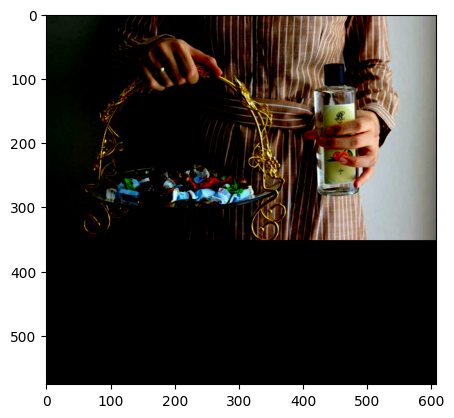

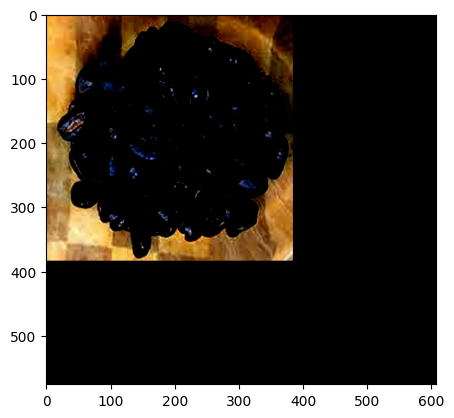

In [5]:
dm = SmallMTDataModuleVILT(_config, dist=False, percentage=1)
dm.setup("test", is_random=True)
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

print("Val Dataloader Length: ", len(val_dataloader))
print("Test Dataloader Length: ", len(test_dataloader))

print(f"Length of the first batch: {len(next(iter(test_dataloader))['answers'])}")
print(f"Shape of the first batch: {next(iter(test_dataloader))['image_0'][0].shape}")

# Plot the first image from the first batch of the test and validation dataloaders
import matplotlib.pyplot as plt
plt.imshow(next(iter(test_dataloader))['image_0'][0][0].permute(1, 2, 0))
plt.show()
plt.imshow(next(iter(val_dataloader))['image_0'][0][0].permute(1, 2, 0))
plt.show()



In [11]:
# =============== Initialize Full Precision Model ==============
model_teacher = ViLTransformerSS(_config)
model_student = ViLTransformerSS(_config)

model_student.eval()
model_teacher.eval()

ViLTransformerSS(
  (text_embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(40, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (token_type_embeddings): Embedding(3, 768)
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (quant): QuantStub()
      (dequant): DeQuantStub()
    )
    (pos_drop): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.1,

In [ ]:
# Freeze all layers except for the specified ones
# Define the modeules to train
modules_to_train = {'layer_names': ["transformer.blocks.0.mlp.fc1",
                                    "transformer.blocks.0.mlp.fc2",]
                    }

freeze_except_layers(model_student, modules_to_train['layer_names'])

# Initialize the KD model
kd_model = KDLightningModule(student_model=model_student, teacher_model=model_teacher, alpha_kd=0.5, lr=2e-4, config=_config)


Layer: transformer.blocks.0.mlp.fc1.weight, Frozen: False
Layer: transformer.blocks.0.mlp.fc1.bias, Frozen: False
Layer: transformer.blocks.0.mlp.fc2.weight, Frozen: False
Layer: transformer.blocks.0.mlp.fc2.bias, Frozen: False


In [13]:
def _register_hooks(pl_module):
    """ Registers hooks to capture the fusion block outputs. """
    def student_hook(module, inp, out):
        pl_module.student_fusion_feats = out
        # print(f"Type of student_fusion_feats: {type(self.student_fusion_feats)}")
        # print(f"Lenght of student_fusion_feats: {len(self.student_fusion_feats)}")
        # print(f"Shape of student_fusion_feats[0]: {self.student_fusion_feats[0].shape}")
        # print(f"Shape of student_fusion_feats[1]: {self.student_fusion_feats[1].shape}")

    # Register hook on the last transformer block
    pl_module.transformer.blocks[-1].register_forward_hook(student_hook)

_register_hooks(model_student)

In [20]:
for i,batch in enumerate(test_dataloader):
    if i == 5:
        break

print(f"Length of the batch: {len(batch)}")


Length of the batch: 10


In [21]:
model_student.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
model_student.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=2)

if model_student.student_fusion_feats is None:
    raise RuntimeError("Fusion layer hooks did not capture outputs!")

Type of student_fusion_feats: <class 'tuple'>
Lenght of student_fusion_feats: 2
Shape of student_fusion_feats[0]: torch.Size([16, 269, 768])
Shape of student_fusion_feats[1]: torch.Size([16, 12, 269, 269])
Type of student_fusion_feats: <class 'tuple'>
Lenght of student_fusion_feats: 2
Shape of student_fusion_feats[0]: torch.Size([16, 257, 768])
Shape of student_fusion_feats[1]: torch.Size([16, 12, 257, 257])


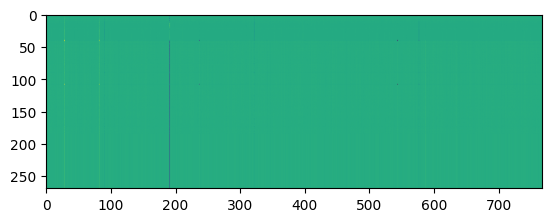

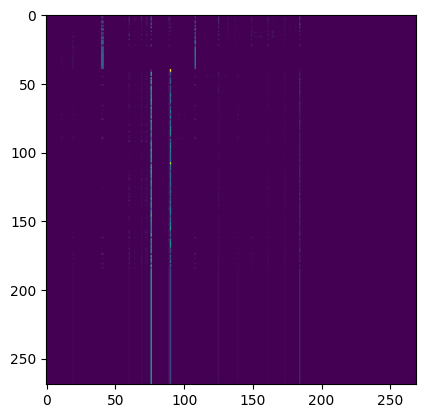

In [16]:
# Plot the first and second instance of the fusion layer output
plt.imshow(model_student.student_fusion_feats[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(model_student.student_fusion_feats[1][0][0].detach().cpu().numpy())
plt.show()